CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
# !pip install captum --user

In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
df = pd.read_csv('hdb_price_prediction.csv')
# TODO: Enter your code here

categorical_cols = ['month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range']

df_train = df[df['year'] <= 2019]
df_val = df[df['year'] == 2020]
df_test = df[df['year'] == 2021]

df_train = df_train.drop(categorical_cols, axis=1)
df_val = df_val.drop(categorical_cols, axis=1)
df_test = df_test.drop(categorical_cols, axis=1)

df_train.head()

,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm,resale_price
0,1.007264,7.006044,0.016807,0.006243,61.333333,44.0,232000.0
1,1.271389,7.983837,0.016807,0.006243,60.583333,67.0,250000.0
2,1.069743,9.090700,0.016807,0.002459,62.416667,67.0,262000.0
3,0.946890,7.519889,0.016807,0.006243,62.083333,68.0,265000.0
4,1.092551,9.130489,0.016807,0.002459,62.416667,67.0,265000.0


> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# TODO: Enter your code here
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

X_train = df_train.drop('resale_price', axis=1).values
y_train = df_train['resale_price'].values

X_val = df_val.drop('resale_price', axis=1).values
y_val = df_val['resale_price'].values

X_test = df_test.drop('resale_price', axis=1).values
y_test = df_test['resale_price'].values

batch_size = 64

#from CustomDataset qA1
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).unsqueeze(1)

X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float).unsqueeze(1)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class hdbModel(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.hdb_stack = nn.Sequential(
        nn.Linear(no_features, no_hidden),
        nn.ReLU(),
        nn.Linear(no_hidden, no_hidden),
        nn.ReLU(),
        nn.Linear(no_hidden, no_labels),
        )

    def forward(self, x):
        return self.hdb_stack(x)

no_features = X_train.shape[1]
no_hidden = 5
no_labels = 1

model = hdbModel(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()



In [5]:
#train model
def train(model, optimizer, loss_fn, dataloader):
    for epoch in range(20):  # loop over the dataset multiple times
        total_loss = 0.0
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            total_loss += loss.item()
            optimizer.step()  

        print(f'Epoch: {epoch+1}, loss is {total_loss}')

        

train(model, optimizer, loss_fn, train_dataloader)

Epoch: 1, loss is 211765250097152.0
Epoch: 2, loss is 159055261704192.0
Epoch: 3, loss is 67216421421056.0
Epoch: 4, loss is 20850430977024.0
Epoch: 5, loss is 15889166213632.0
Epoch: 6, loss is 15572137864704.0
Epoch: 7, loss is 15232851351040.0
Epoch: 8, loss is 14861981542912.0
Epoch: 9, loss is 14480806257664.0
Epoch: 10, loss is 14099750714368.0
Epoch: 11, loss is 13724530486784.0
Epoch: 12, loss is 13356303664128.0
Epoch: 13, loss is 12986069320704.0
Epoch: 14, loss is 12622191424000.0
Epoch: 15, loss is 12256113217792.0
Epoch: 16, loss is 11884834610688.0
Epoch: 17, loss is 11504605712640.0
Epoch: 18, loss is 11115553202176.0
Epoch: 19, loss is 10718865754368.0
Epoch: 20, loss is 10311290560768.0


In [6]:
sl = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

test_cases = 2000 #reduce time taken
sl_atr_test = sl.attribute(X_test[:test_cases])
ixg_atr_test = ixg.attribute(X_test[:test_cases])
ig_atr_test = ig.attribute(X_test[:test_cases], n_steps=50)
gs_atr_test = gs.attribute(X_test[:test_cases], X_train)
fa_atr_test = fa.attribute(X_test[:test_cases])

c:\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


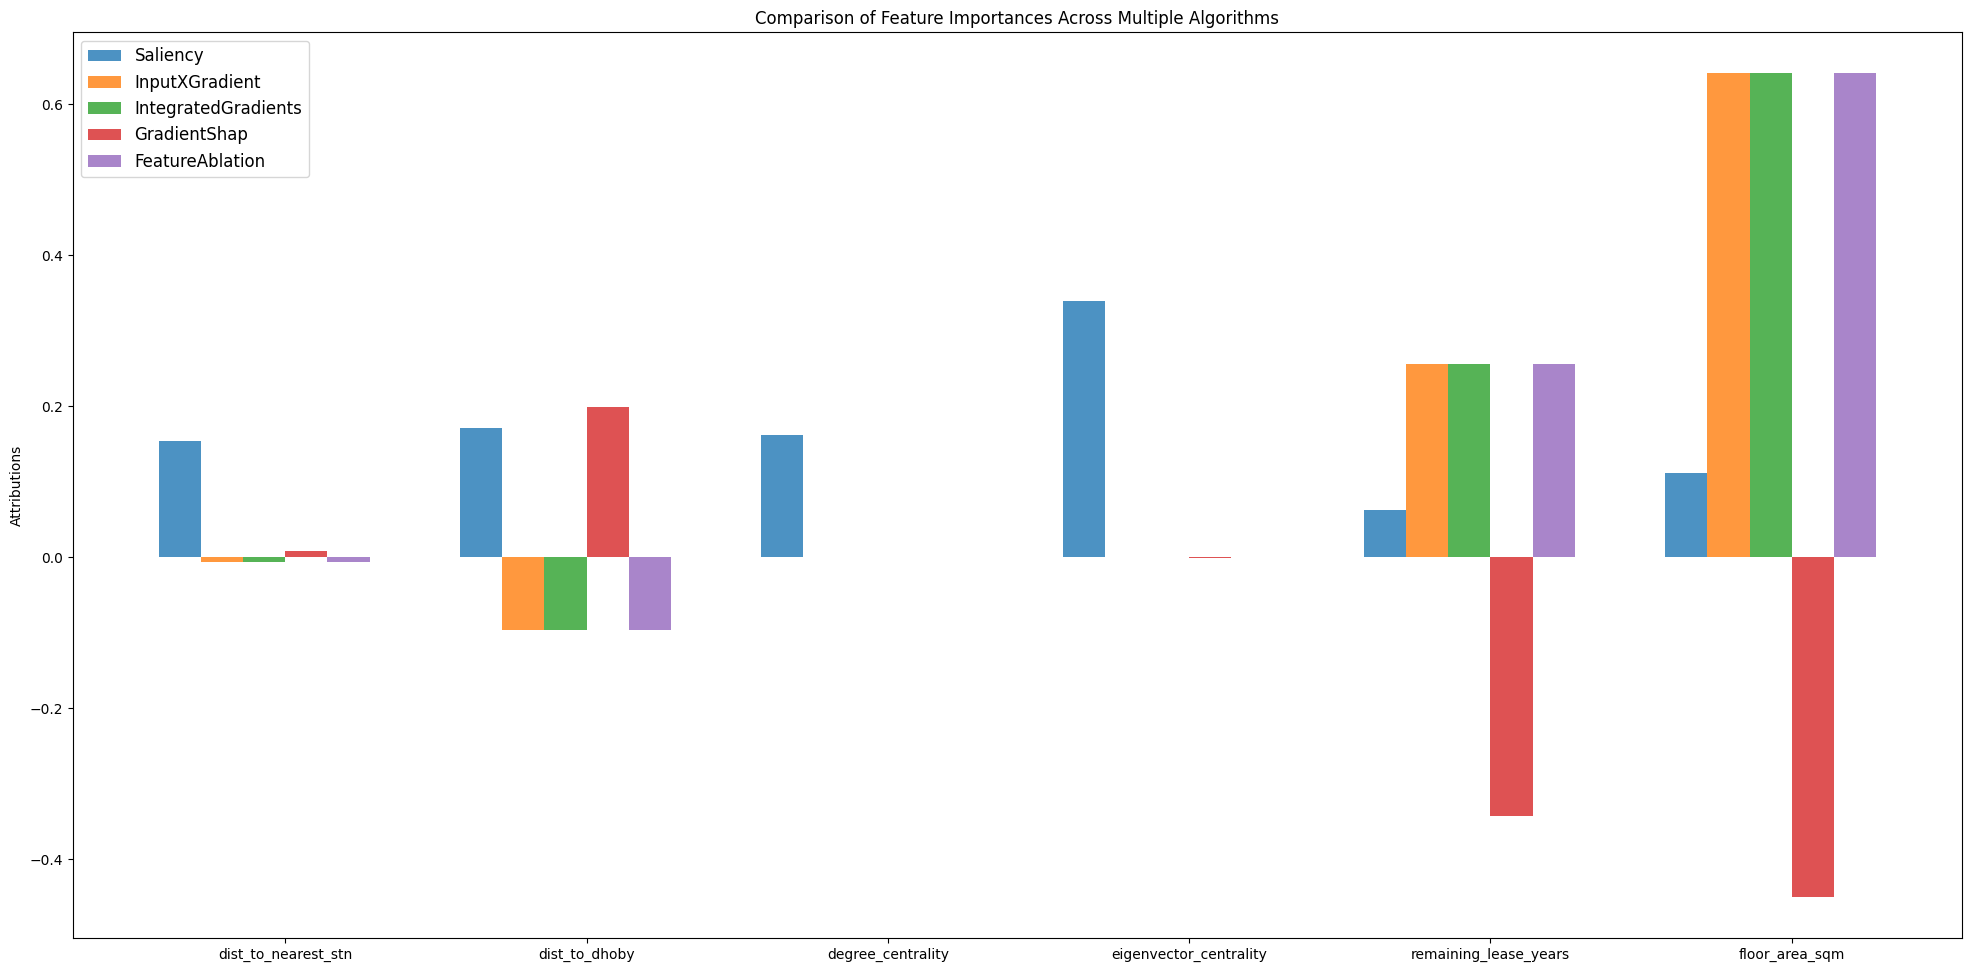

In [7]:
import matplotlib.pyplot as plt

# Define the feature names
feature_names = df_train.drop(['resale_price'], axis=1).columns

# Prepare attribution values
attributions = [
    ('Saliency', sl_atr_test),
    ('InputXGradient', ixg_atr_test),
    ('IntegratedGradients', ig_atr_test),
    ('GradientShap', gs_atr_test),
    ('FeatureAblation', fa_atr_test)
]

# Compute and normalize the sums
normalized_attributions = []
for name, attribution in attributions:
    sum_values = attribution.detach().numpy().sum(0)
    normalized_sum = sum_values / np.linalg.norm(sum_values, ord=1)
    normalized_attributions.append((name, normalized_sum))

# Set up the plot
width = 0.14
legends = [name for name, _ in normalized_attributions]

plt.figure(figsize=(20, 10))
ax = plt.subplot()
ax.set_title('Comparison of Feature Importances Across Multiple Algorithms')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE - 4)

# Plot the data
x_axis_data = np.arange(len(feature_names))
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

for i, (name, normalized_sum) in enumerate(normalized_attributions):
    ax.bar(x_axis_data + i * width, normalized_sum, width, align='center', alpha=0.8, label=name)

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + (len(attributions) / 2) * width)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [10]:
# TODO: Enter your code here
from sklearn.preprocessing import StandardScaler

# perform scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float)

X_val_scaled = scaler.transform(X_val)
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float)

batch_size = 64
train_dataset_scaled = TensorDataset(X_train_scaled, y_train)
train_dataloader_scaled = DataLoader(train_dataset_scaled, batch_size=batch_size, shuffle=True)

val_dataset_scaled = TensorDataset(X_val_scaled, y_val)
val_dataloader_scaled = DataLoader(val_dataset_scaled, batch_size=batch_size, shuffle=True)

test_dataset_scaled = TensorDataset(X_test_scaled, y_test)
test_datalaoder_scaled = DataLoader(test_dataset_scaled, batch_size=batch_size, shuffle=True)

# Create model, optimizer and loss functions
model = hdbModel(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train model on scaled data
train(model, optimizer, loss_fn, train_dataloader_scaled)

Epoch: 1, loss is 216541824532480.0
Epoch: 2, loss is 216134097207296.0
Epoch: 3, loss is 214960922673152.0
Epoch: 4, loss is 212827783856128.0
Epoch: 5, loss is 209622899933184.0
Epoch: 6, loss is 205256866021376.0
Epoch: 7, loss is 199678018486272.0
Epoch: 8, loss is 192860394651648.0
Epoch: 9, loss is 184795627626496.0
Epoch: 10, loss is 175482841022464.0
Epoch: 11, loss is 165008803135488.0
Epoch: 12, loss is 153473305010176.0
Epoch: 13, loss is 141019371479040.0
Epoch: 14, loss is 127868826271744.0
Epoch: 15, loss is 114272174202880.0
Epoch: 16, loss is 100509703843840.0
Epoch: 17, loss is 86928242384896.0
Epoch: 18, loss is 73912119975936.0
Epoch: 19, loss is 61836407107584.0
Epoch: 20, loss is 51060820779008.0


In [11]:
sl = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

test_cases = 2000 #reduce time taken
sl_atr_test = sl.attribute(X_test[:test_cases])
ixg_atr_test = ixg.attribute(X_test[:test_cases])
ig_atr_test = ig.attribute(X_test[:test_cases], n_steps=50)
gs_atr_test = gs.attribute(X_test[:test_cases], X_train)
fa_atr_test = fa.attribute(X_test[:test_cases])

c:\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


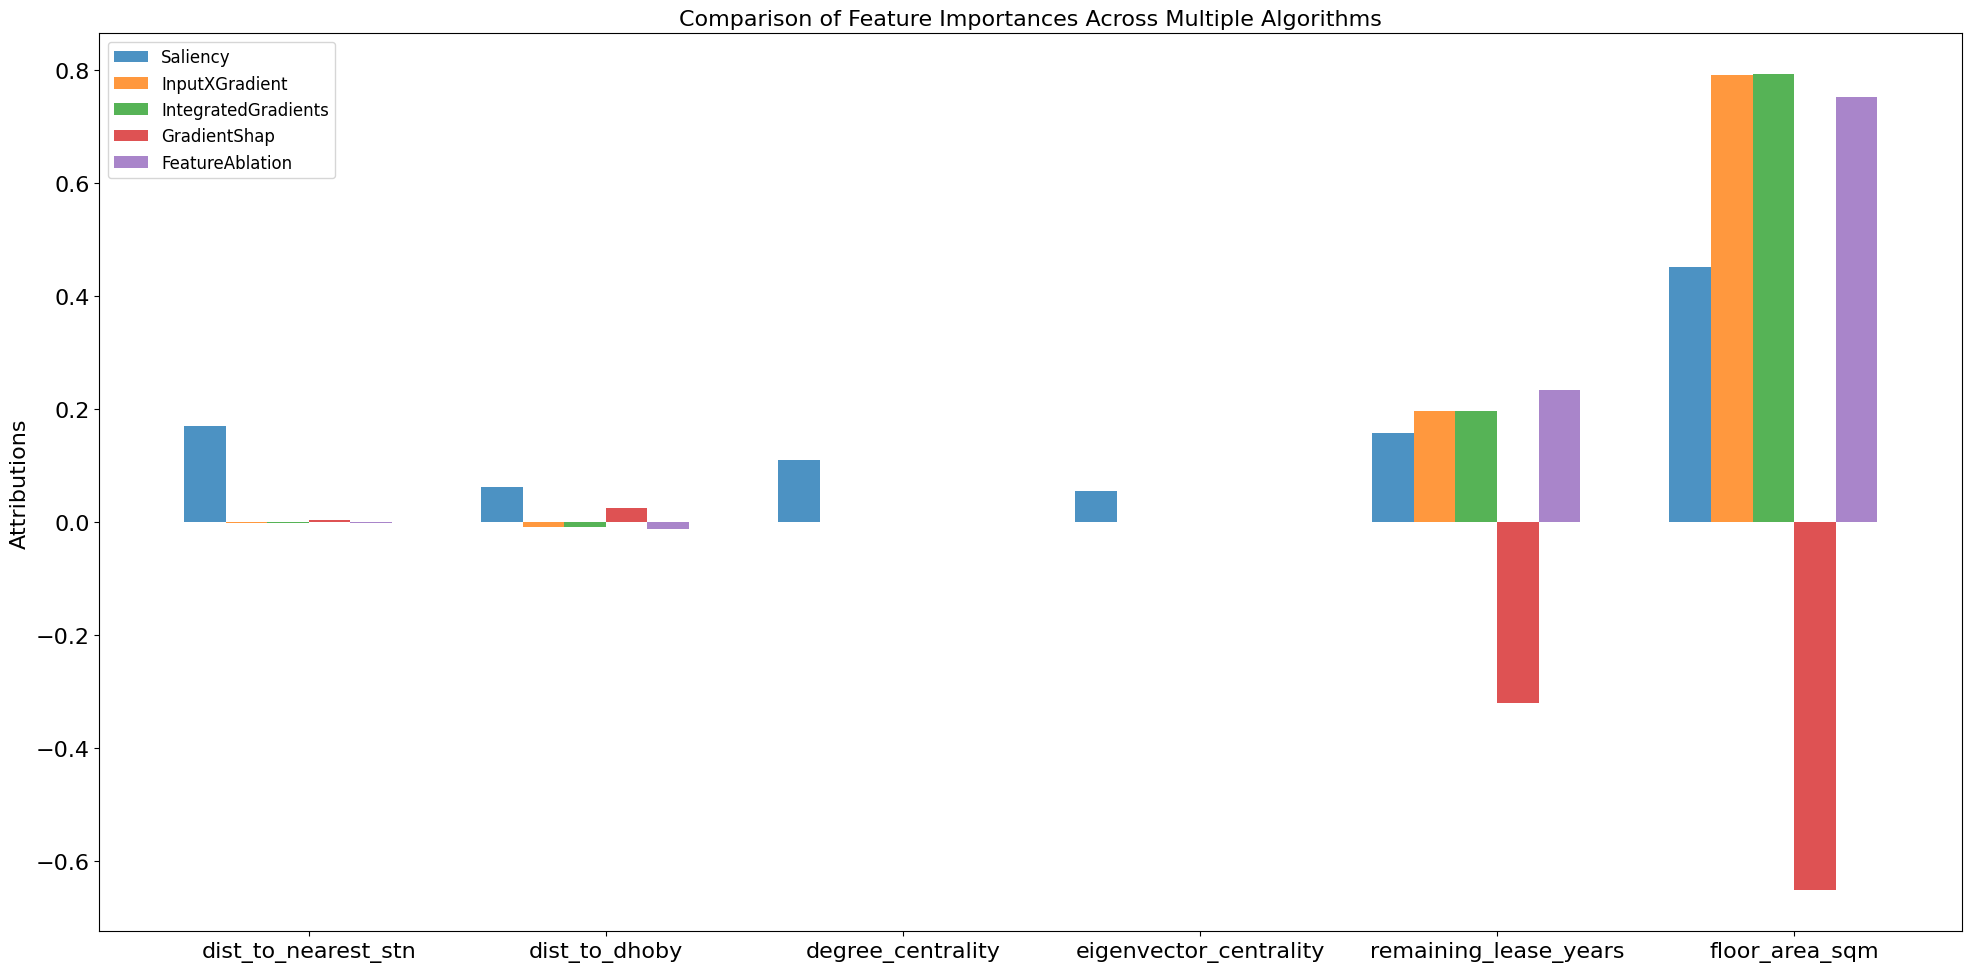

In [12]:
import matplotlib.pyplot as plt

# Define the feature names
feature_names = df_train.drop(['resale_price'], axis=1).columns

# Prepare attribution values
attributions = [
    ('Saliency', sl_atr_test),
    ('InputXGradient', ixg_atr_test),
    ('IntegratedGradients', ig_atr_test),
    ('GradientShap', gs_atr_test),
    ('FeatureAblation', fa_atr_test)
]

# Compute and normalize the sums
normalized_attributions = []
for name, attribution in attributions:
    sum_values = attribution.detach().numpy().sum(0)
    normalized_sum = sum_values / np.linalg.norm(sum_values, ord=1)
    normalized_attributions.append((name, normalized_sum))

# Set up the plot
width = 0.14
legends = [name for name, _ in normalized_attributions]

plt.figure(figsize=(20, 10))
ax = plt.subplot()
ax.set_title('Comparison of Feature Importances Across Multiple Algorithms')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE - 4)

# Plot the data
x_axis_data = np.arange(len(feature_names))
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

for i, (name, normalized_sum) in enumerate(normalized_attributions):
    ax.bar(x_axis_data + i * width, normalized_sum, width, align='center', alpha=0.8, label=name)

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + (len(attributions) / 2) * width)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends)
plt.show()

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


This is so as Sasliency and Integrated Gradients are both gradient-based techniques used to attribute feature importances. They analyse the gradients of the model's output with respect to the input features. Saliency can be considered the simplified form of Integrated Gradients. Integrated Gradients considers the cumulative sum of gradients along a path from a baseline input to the actual input.

> Why did Input x Gradients give the same attribution scores as IG?


Both InputXGradient and Integrated Gradients both rely on gradient information. For IXG,  it calculates the derivative of the moddel's output with respect to input features. IXG = ∂(Model Output) / ∂(Input Features). For IG, it is an extention of IXG, by integrating gradients along a path from a baseline input to the actual input. IG = (Input - Baseline) * ∫ [∂(Model Output) / ∂(Input Features)] dα

Since both methods use derivatives to calculate attributiion scores, it can result in same scores when the model behavior is linear.